In [1]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os,sys,gc
import numpy as np
import pickle
import torch
import proplot as plot
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
import glob

sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/scikit/')
from tools import derive_var,read_and_proc
from tools.mlr import mlr
#from tools.preprocess import preproc_maria,preproc_haiyan
sys.path.insert(1, '../')
import read_stuff as read
import ts_models
import properscoring as ps
#import benchmark
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

In [2]:
import random
def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)                       
    torch.manual_seed(seed)                    
    torch.cuda.manual_seed(seed)               
    torch.cuda.manual_seed_all(seed)           
    torch.backends.cudnn.deterministic = True  
setup_seed(42)

In [3]:
from tqdm.auto import tqdm
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()
del a
gc.collect()

  0%|          | 0/20 [00:00<?, ?it/s]

16007

In [4]:
def prepare_tensors(filepath='./haiyan_store',splitnum=None,explag=23,notensor='No'):
    Xtrain = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*')[0])['uvwthhdialwsw']['train']
    Xvalid = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*')[0])['uvwthhdialwsw']['valid']
    Xtest = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*')[0])['uvwthhdialwsw']['test']
    
    ytrain = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*')[0])['train'][explag]
    yvalid = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*')[0])['valid'][explag]
    ytest = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*')[0])['test'][explag]
    
    X_totrain, y_totrain = read.delete_padding(Xtrain,ytrain)
    X_tovalid, y_tovalid = read.delete_padding(Xvalid,yvalid)
    X_totest, y_totest = read.delete_padding(Xtest,ytest)
    
    if notensor=='No':
        calc_device = 'cpu'
        ###################################################################################
        # Convert numpy arrays into tensors
        ###################################################################################
        train_Xtensor = torch.FloatTensor(X_totrain).to(calc_device)
        train_ytensor = torch.FloatTensor(y_totrain).to(calc_device)
        val_Xtensor = torch.FloatTensor(X_tovalid).to(calc_device)
        val_ytensor = torch.FloatTensor(y_tovalid).to(calc_device)
        test_Xtensor = torch.FloatTensor(X_totest).to(calc_device)
        test_ytensor = torch.FloatTensor(y_totest).to(calc_device)
        #train_data = torch.utils.data.TensorDataset(train_Xtensor, train_ytensor)
        #val_data = torch.utils.data.TensorDataset(val_Xtensor, val_ytensor)
        #test_data = torch.utils.data.TensorDataset(test_Xtensor, test_ytensor)
        
        return {'train':[train_Xtensor,train_ytensor],'valid':[val_Xtensor,val_ytensor],'test':[test_Xtensor,test_ytensor]}
    elif notensor=='Yes':
        return {'train':[X_totrain, y_totrain],'valid':[X_tovalid, y_tovalid],'test':[X_totest, y_totest]}

storedata,store_notensor = {},{}
for i in range(0,40):
    storedata[i] = prepare_tensors('./haiyan_store',i,23,'No')
    store_notensor[i] = prepare_tensors('./haiyan_store',i,23,'Yes')

In [5]:
import benchmark
import importlib
importlib.reload(benchmark)

<module 'benchmark' from '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/finalver/benchmark.py'>

In [6]:
droprates = [0,0.001,0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
r2_performance = {droprate: benchmark.get_performances(datasets=storedata,datasets_notensor=store_notensor,numsplits=40,modelpath='./haiyan_store/dropout/',
                     droprate=droprate,metric='r2',trailnums=50,withspread=True,output_type='Drop1_2') for droprate in droprates}

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [7]:
crps_performance = [benchmark.get_performances(datasets=storedata,datasets_notensor=store_notensor,numsplits=40,modelpath='./haiyan_store/dropout/',
                     droprate=droprate,metric='crps',trailnums=50,withspread=True,output_type='Drop1_2') for droprate in droprates]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

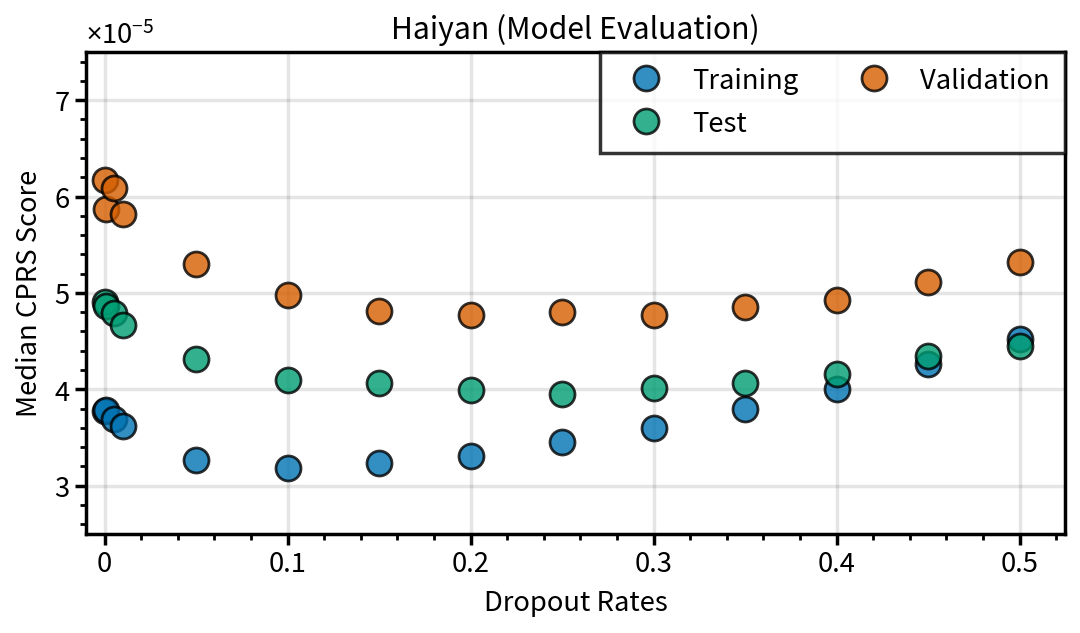

In [8]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.895,refaspect=2.031)
axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2trains'] for i in range(40)])) for obj in crps_performance],lw=0,label='Training',marker='o',mfc='C0',mew=1,mec='k',markersize=9,alpha=0.8)
axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2vals'] for i in range(40)])) for obj in crps_performance],lw=0,label='Validation',marker='o',mfc='C1',mew=1,mec='k',markersize=9,alpha=0.8)
axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2tests'] for i in range(40)])) for obj in crps_performance],lw=0,label='Test',marker='o',mfc='C2',mew=1,mec='k',markersize=9,alpha=0.8)
axs.legend(loc=1,ncols=2)
axs.format(xlabel='Dropout Rates',ylabel='Median CPRS Score',title='Haiyan (Model Evaluation)',ylim=[2.5e-5,7.5e-5],xlim=[-0.01,0.525])
plt.savefig('../analysis/pic/climateinfo/CPRSmedian_revised_haiyan.png',dpi=600)
plt.show()

In [24]:
performances = [(([obj[i]['r2vals'] for i in range(40)])) for obj in crps_performance][7]
storems = {}
for i in range(len(performances[0])):
    storems[i] = ([performances[j][i] for j in range(len(performances))])
    
modelnum = np.asarray([np.mean(np.asarray(storems[key])) for key in storems.keys()]).argmin()
valsplit = np.asarray(storems[modelnum]).argmin()
bestmodel = r2_performance[0][int(valsplit)]['models'][int(modelnum)][0]
pcalw,pcasw = read_and_proc.depickle('./haiyan_store/pca/lw/'+str(valsplit)+'/PCA3D.pkg'),read_and_proc.depickle('./haiyan_store/pca/sw/'+str(valsplit)+'/PCA3D.pkg')

In [25]:
def new_structure(X_totrain=None,bestmodel=None,TYPE='LW'):
    LW,SW = (np.asarray(X_totrain)[:,-40:-20]),(np.asarray(X_totrain)[:,-20:])
    store = []
    for i in range(20):
        if TYPE=='LW':
            term1 = benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()[i]#benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[0]*benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()[i]
            sumss = np.sqrt(np.sum((benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()/np.std(LW,axis=0))**2))
            term2 = (np.std(LW[:,i])*sumss)
            store.append(np.sign(benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[0])*term1/term2)
        elif TYPE=='SW':
            term1 = benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()[i]#benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[1]*benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()[i]
            sumss = np.sqrt(np.sum((benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()/np.std(SW,axis=0))**2))
            term2 = (np.std(SW[:,i])*sumss)
            store.append(np.sign(benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[1])*term1/term2)
    return store

def new_structure_nosign(X_totrain=None,bestmodel=None,TYPE='LW'):
    LW,SW = (np.asarray(X_totrain)[:,-40:-20]),(np.asarray(X_totrain)[:,-20:])
    store = []
    for i in range(20):
        if TYPE=='LW':
            term1 = benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()[i]#benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[0]*benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()[i]
            sumss = np.sqrt(np.sum((benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()/np.std(LW,axis=0))**2))
            term2 = (np.std(LW[:,i])*sumss)
            store.append((benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[0])*term1/term2)
        elif TYPE=='SW':
            term1 = benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()[i]#benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[1]*benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()[i]
            sumss = np.sqrt(np.sum((benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()/np.std(SW,axis=0))**2))
            term2 = (np.std(SW[:,i])*sumss)
            store.append((benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[1])*term1/term2)
    return store

In [26]:
bestmodel = r2_performance[0][int(valsplit)]['models'][int(modelnum)][0]
fl = new_structure(store_notensor[valsplit]['train'][0],bestmodel,'LW')
flsw = new_structure(store_notensor[valsplit]['train'][0],bestmodel,'SW')
flas = np.squeeze(np.dot(fl,pcalw['lw'].components_[:20,:])).reshape(10,360,208)
flas_sw = np.squeeze(np.dot(flsw,pcasw['sw'].components_[:20,:])).reshape(10,360,208)

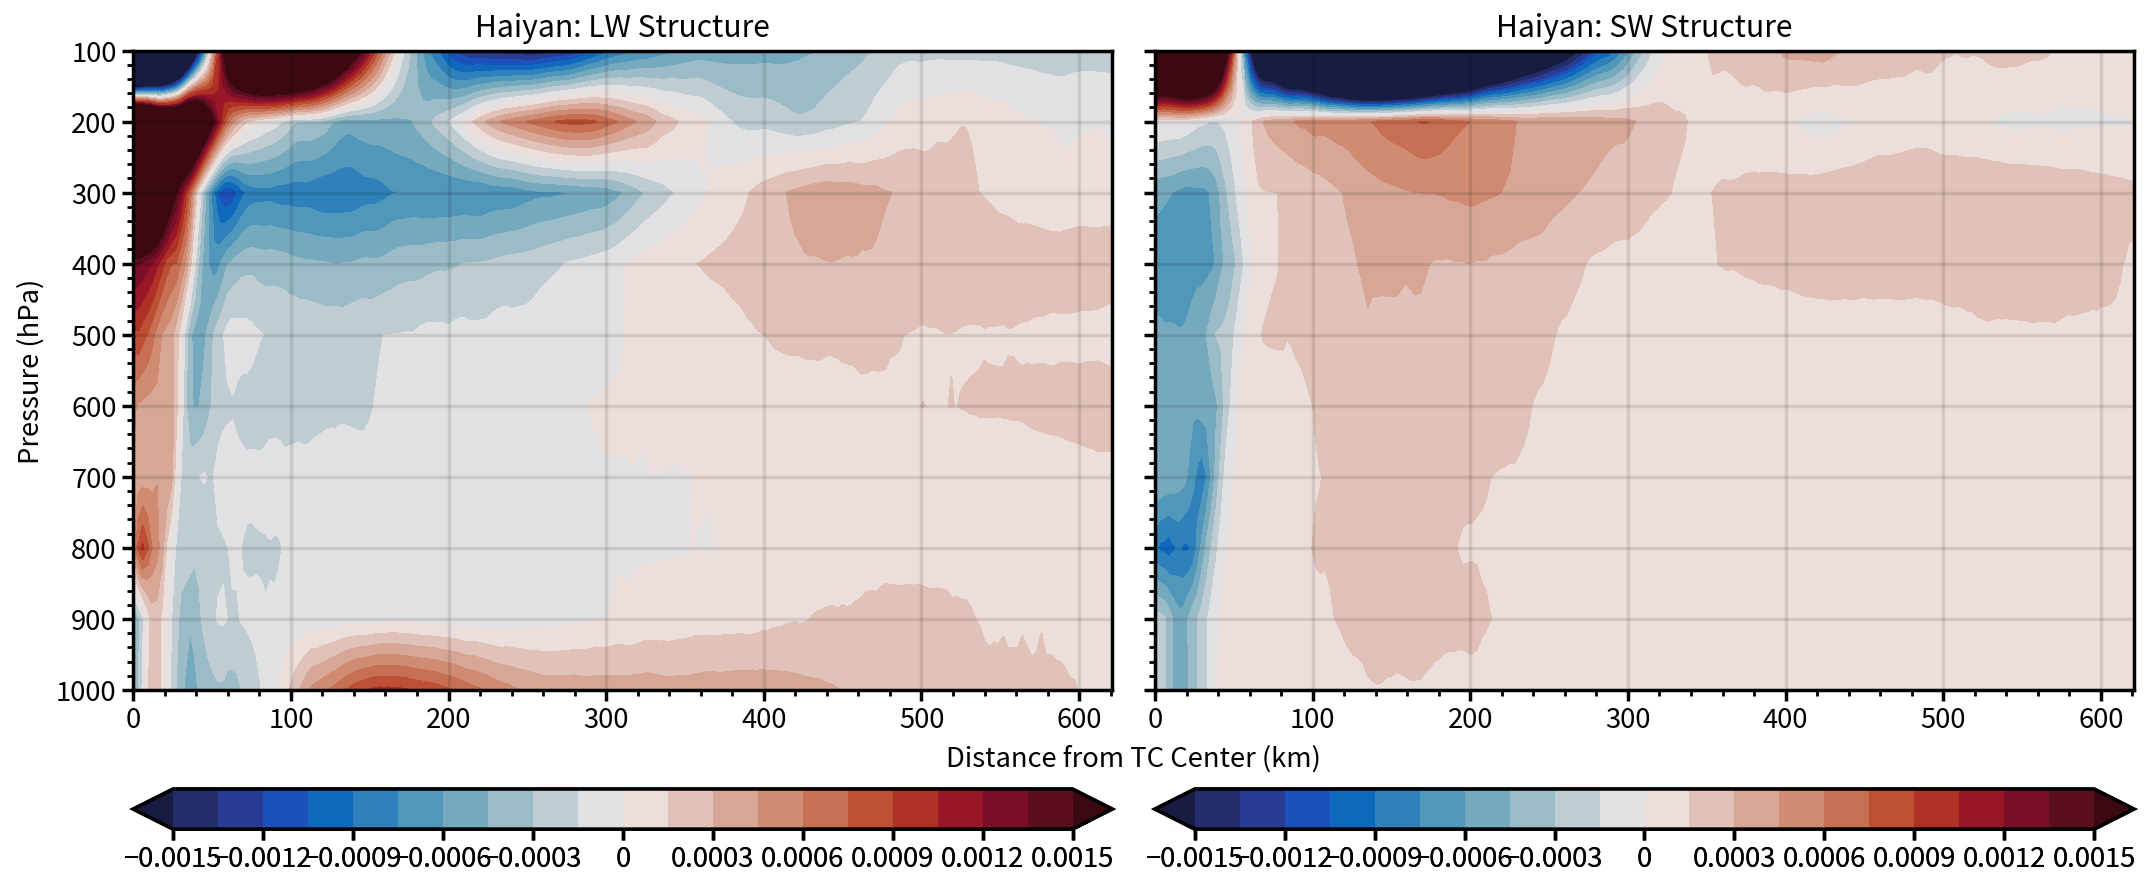

In [27]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=4.895,refaspect=1.531)
img = axs[0].contourf(np.linspace(0,207,208)*3,np.linspace(1000,100,10),np.mean(flas,axis=1),cmap='balance',levels=np.linspace(-1.5e-3,1.5e-3,21),extend='both')#vmin=-0.5e-5,vmax=0.5e-5)
axs[0].colorbar(img,loc='b')
axs[0].format(xlabel='Distance from TC Center (km)',ylabel='Pressure (hPa)',title='Haiyan: LW Structure')
img2 = axs[1].contourf(np.linspace(0,207,208)*3,np.linspace(1000,100,10),np.mean(flas_sw,axis=1),cmap='balance',levels=np.linspace(-1.5e-3,1.5e-3,21),extend='both')
axs[1].colorbar(img2,loc='b')
axs[1].format(xlabel='Distance from TC Center (km)',ylabel='Pressure (hPa)',title='Haiyan: SW Structure')
plt.savefig('../analysis/pic/climateinfo/optimstructures_revised_haiyan.png',dpi=600)
plt.show()

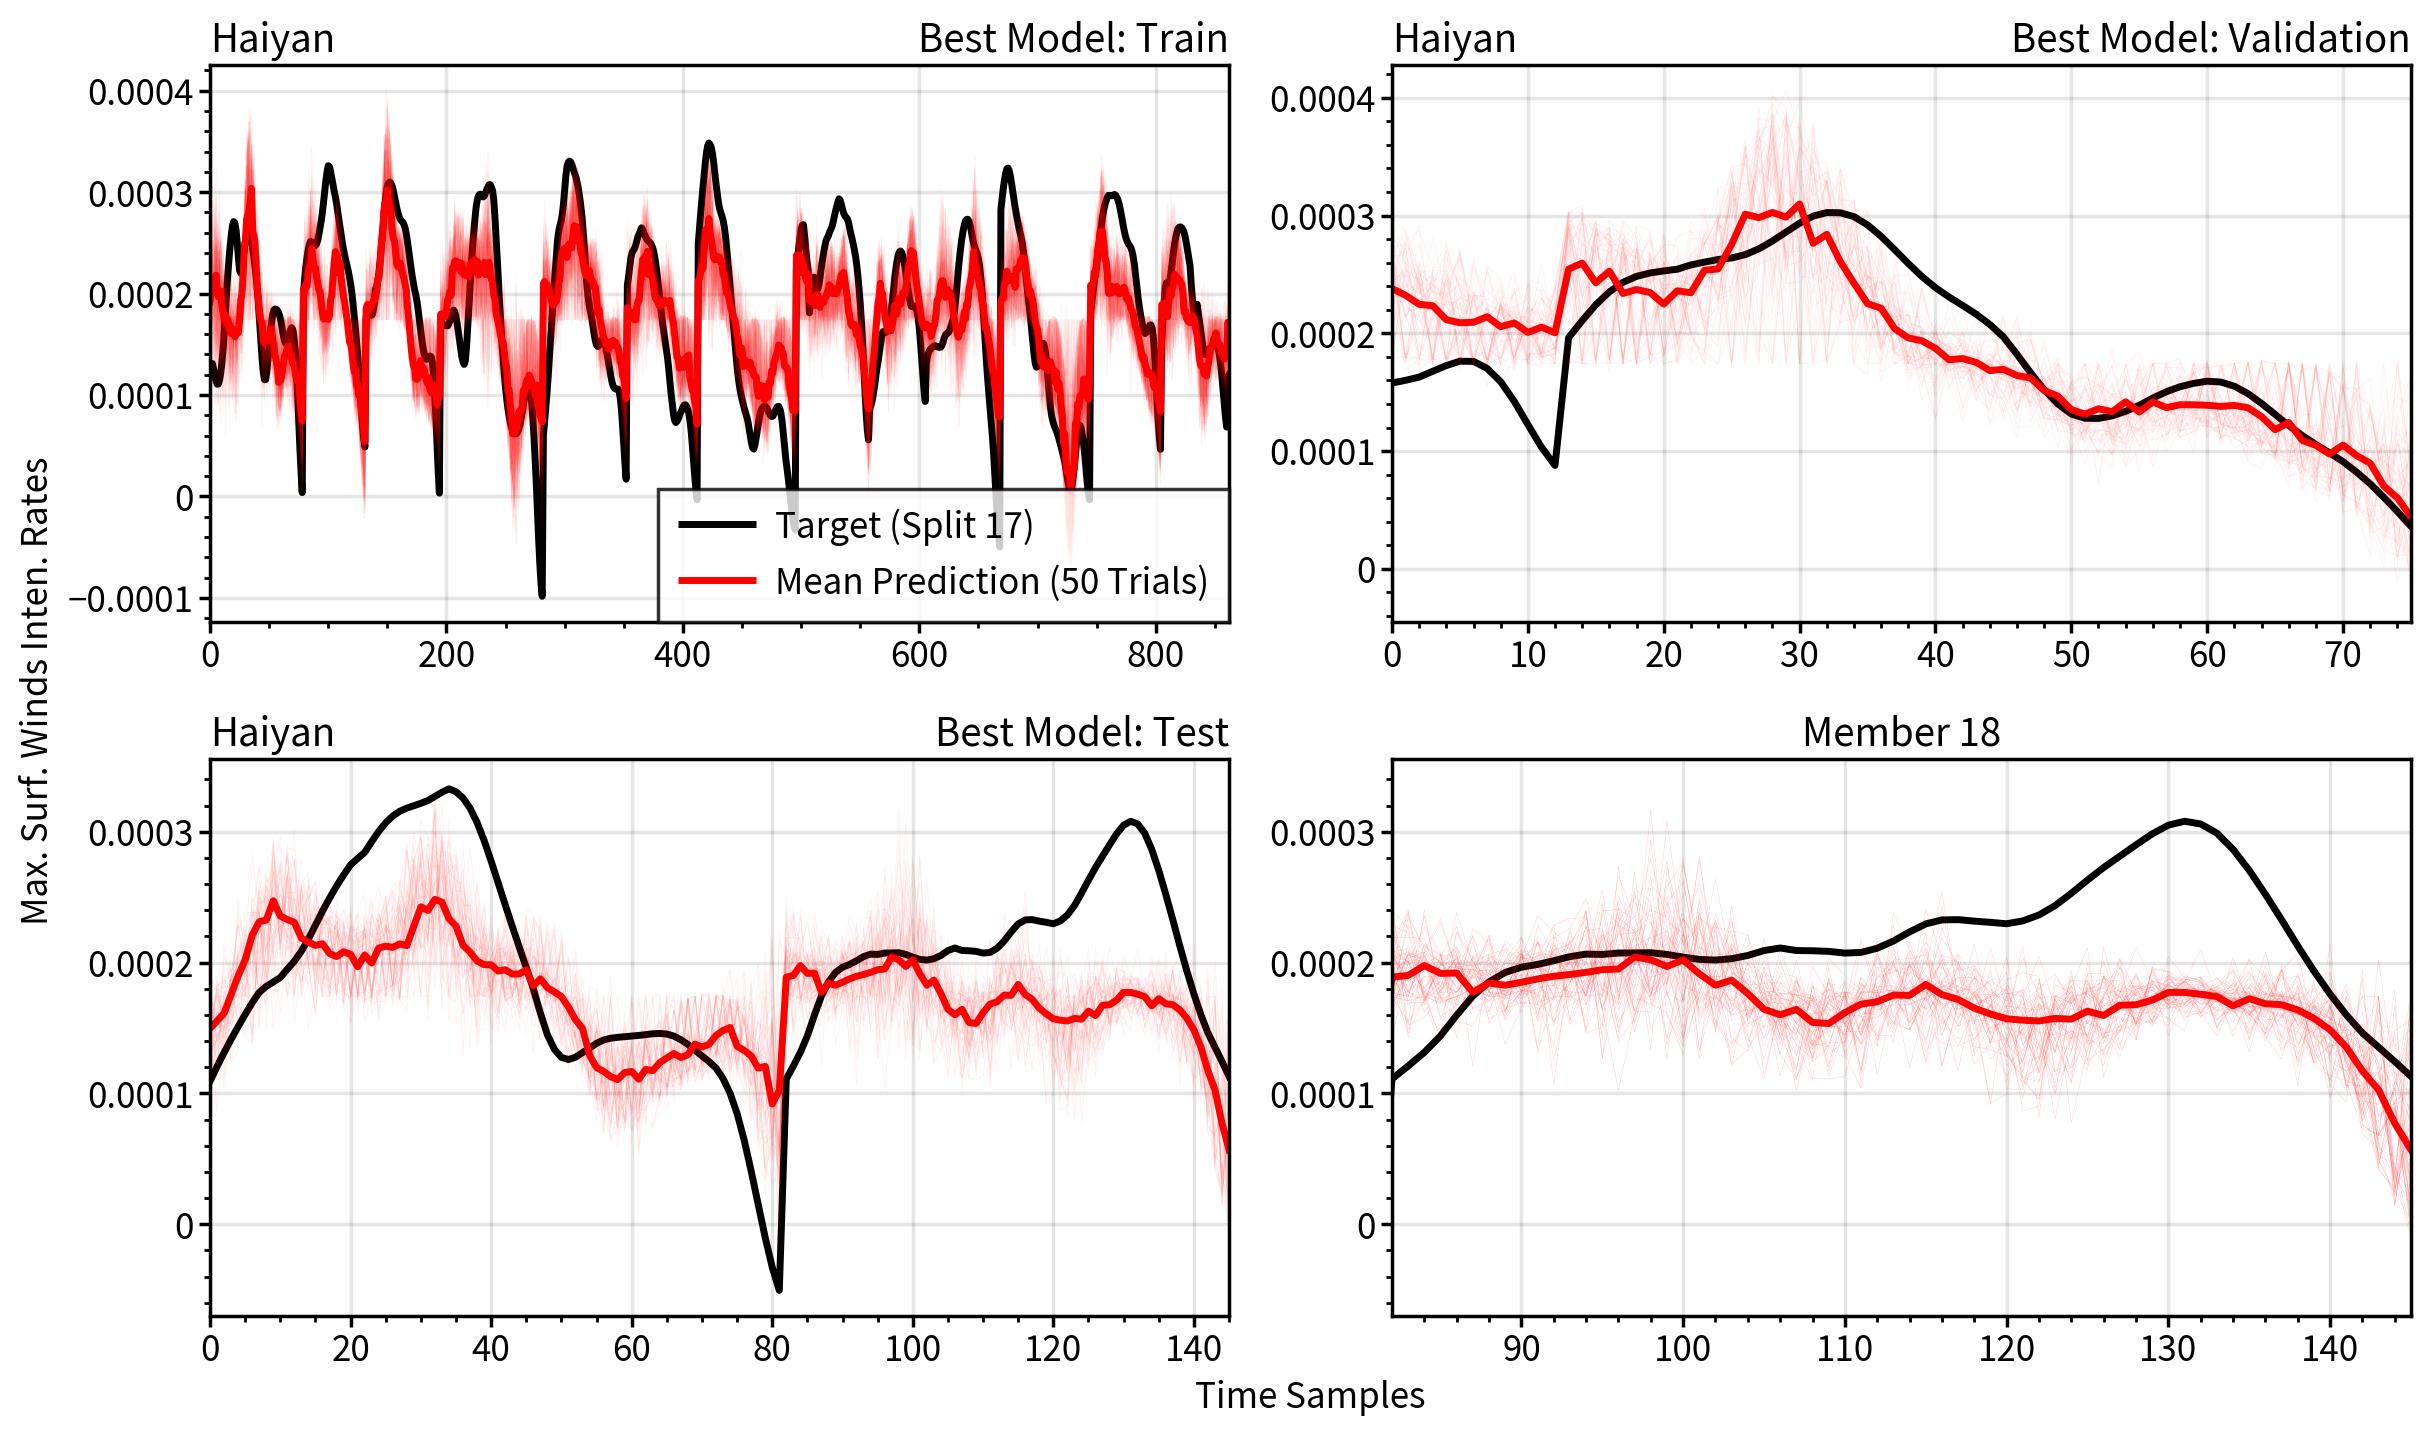

In [197]:
from sklearn.metrics import r2_score
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 14.05,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

accesscode = 0.2
fig,axs = plot.subplots(ncols=2,nrows=2,axwidth=5.095,refaspect=1.831,share=1)
axs[0].plot(store_notensor[valsplit]['train'][1],label=f'Target (Split {valsplit})',c='k',lw=2.5)#79:132])
axs[0].plot(r2_performance[accesscode][int(valsplit)]['meantrains'][int(modelnum)],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])

allpreds = r2_performance[accesscode][int(valsplit)]['alltrains'][int(modelnum)]
for pred in allpreds:
    axs[0].plot(pred,c='r',lw=0.35,alpha=0.05)
axs[0].legend(loc=4,ncols=1)
r2_scoress = r2_score(store_notensor[valsplit]['train'][1],r2_performance[accesscode][int(valsplit)]['meantrains'][int(modelnum)])
axs[0].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Haiyan',rtitle=f'Best Model: Train')

axs[1].plot(store_notensor[valsplit]['valid'][1],label=f'Target (Split {valsplit})',c='k',lw=2.5)#79:132])
axs[1].plot(r2_performance[accesscode][int(valsplit)]['meanvals'][int(modelnum)],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])
allpreds = r2_performance[accesscode][int(valsplit)]['allvals'][int(modelnum)]
for pred in allpreds:
    axs[1].plot(pred,c='r',lw=0.35,alpha=0.05)
#r2_scoress = r2_score(y_toval,r2_performance[accesscode][int(valsplit)]['meanvals'][int(modelnum)])
axs[1].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Haiyan',rtitle=f'Best Model: Validation')#,rtitle='Optimal Longwave')
#plt.savefig('../analysis/pic/climateinfo/MCdropout_testskill_revised.png',dpi=600)

axs[2].plot(store_notensor[valsplit]['test'][1],label=f'Target (Split {valsplit})',c='k',lw=2.5)#79:132])
axs[2].plot(r2_performance[accesscode][int(valsplit)]['meantests'][int(modelnum)],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])
allpreds = r2_performance[accesscode][int(valsplit)]['alltests'][int(modelnum)]
for pred in allpreds:
    axs[2].plot(pred,c='r',lw=0.35,alpha=0.05)
#r2_scoress = r2_score(y_totest,r2_performance[accesscode][int(valsplit)]['meantests'][int(modelnum)])
axs[2].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Haiyan',rtitle=f'Best Model: Test')#,rtitle='Optimal Longwave')

axs[3].plot(store_notensor[valsplit]['test'][1],c='k',lw=2.5)
axs[3].plot(r2_performance[accesscode][int(valsplit)]['meantests'][int(modelnum)],label='Mean Prediction (50 Trials)',c='r',lw=2.5)

allpres = r2_performance[accesscode][int(valsplit)]['alltests'][int(modelnum)]
for allpre in allpres:
    axs[3].plot(allpre,label='Mean Prediction (50 Trials)',c='r',lw=0.15,alpha=0.22)
axs[3].format(xlim=[82,145],title='Member 18')
plt.savefig('../analysis/pic/climateinfo/paper_fig2_haiyan_revised.png',dpi=600)
plt.show()

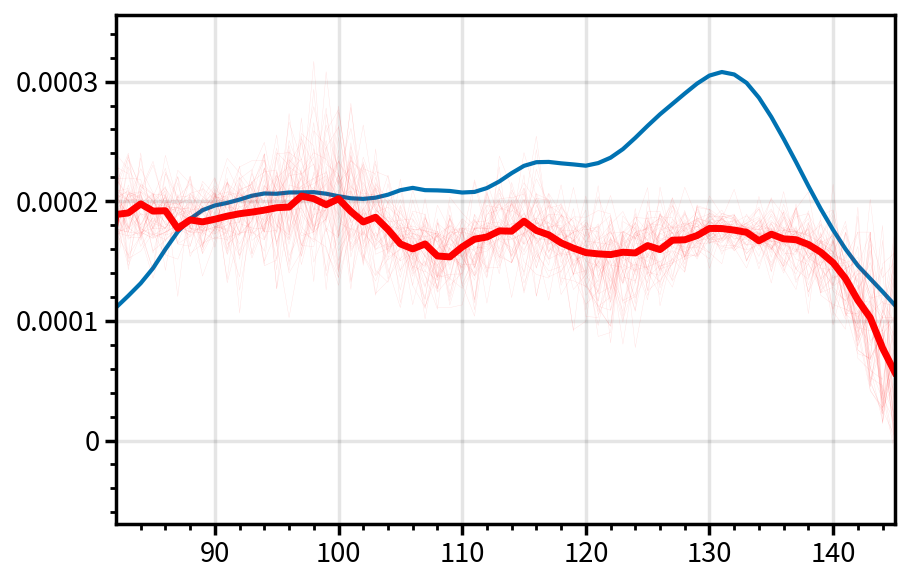

In [62]:
accesscode = 0.2
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.895,refaspect=1.531)
axs[0].plot(store_notensor[valsplit]['test'][1])
axs[0].plot(r2_performance[accesscode][int(valsplit)]['meantests'][int(modelnum)],label='Mean Prediction (50 Trials)',c='r',lw=2.5)

allpres = r2_performance[accesscode][int(valsplit)]['alltests'][int(modelnum)]
for allpre in allpres:
    axs[0].plot(allpre,label='Mean Prediction (50 Trials)',c='r',lw=0.15,alpha=0.12)
axs[0].format(xlim=[82,145])
#plt.xlim(82,145)
plt.show()

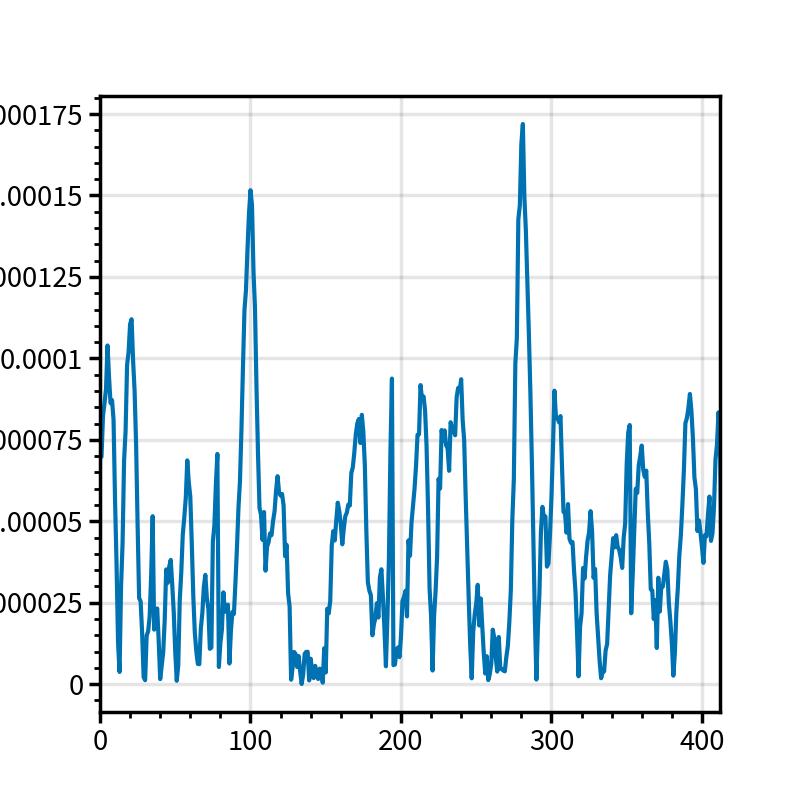

In [169]:
error = np.abs(r2_performance[accesscode][int(valsplit)]['meantrains'][int(modelnum)]-store_notensor[valsplit]['train'][1])
#plt.plot(np.std(np.asarray(allpres),axis=0))
plt.plot(error)
plt.xlim(0,412)
plt.show()

In [67]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/store/'
folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/'
read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').where_exp_MLRpred(divider=divider,num=40,expnum=2,LT=24)

,start,end,exp,size
0,132,195,train,63
1,132,195,train,63
2,132,195,train,63
3,132,195,train,63
4,132,195,train,63
5,132,195,train,63
6,132,195,train,63
7,132,195,train,63
8,132,195,train,63
9,132,195,train,63


In [72]:
storeLOCS = []
for i in tqdm(range(20)):
    storeLOCS.append(read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').where_exp_MLRpred(divider=divider,num=40,expnum=i,LT=24).iloc[valsplit])

  0%|          | 0/20 [00:00<?, ?it/s]

In [90]:
exp,start,end = [obj['exp'] for obj in storeLOCS],[obj['start'] for obj in storeLOCS],[obj['end'] for obj in storeLOCS]

In [193]:
exp

['train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'valid',
 'train',
 'train',
 'test',
 'train',
 'train',
 'train',
 'train',
 'valid',
 'train',
 'test',
 'train',
 'train']

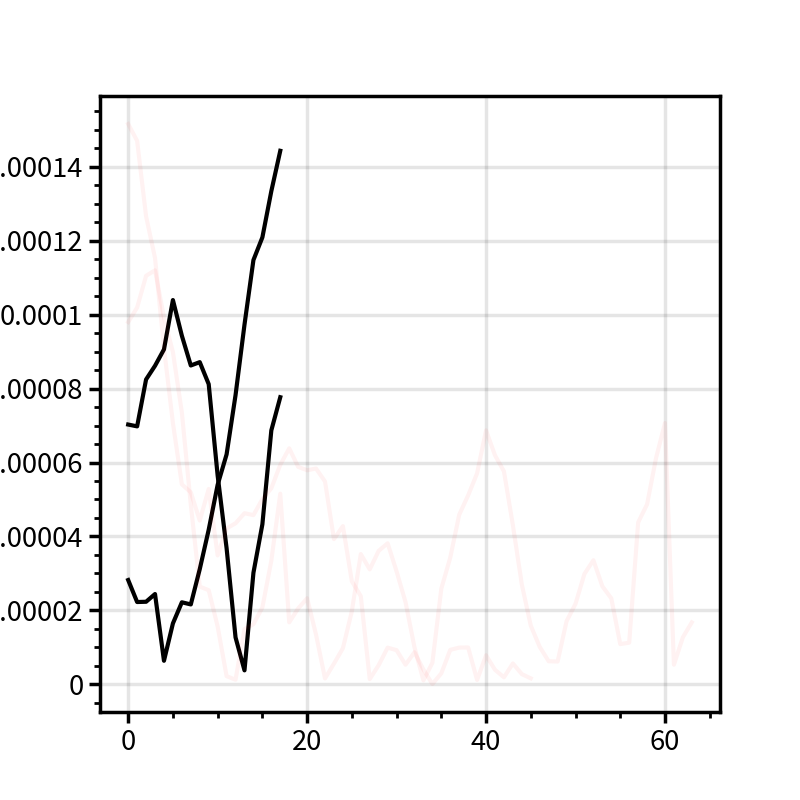

In [184]:
for i in error_early:
    plt.plot(i,c='k')
for j in error_later:
    plt.plot(j,c='r',alpha=0.05)
plt.show()

In [185]:
error = np.abs(r2_performance[accesscode][int(valsplit)]['meantests'][int(modelnum)]-store_notensor[valsplit]['test'][1])
error_early,error_later = [],[]
for i in range(20):
    if exp[i]=='test':
        if i==0:
            error_early.append(error[0:18])
            error_later.append(error[18:79])
        if end[i]-start[i]<24:
            continue
        else:
            print(start[i],end[i])
            error_early.append(error[start[i]:start[i]+18])
            error_later.append(error[start[i]+18:end[i]])
    else:
        continue

0 82
82 146


In [186]:
from scipy.stats import kstest,ttest_ind

In [187]:
ttest_ind(np.asarray(read_and_proc.flatten(error_early)),np.asarray(read_and_proc.flatten(error_later)))

Ttest_indResult(statistic=-4.740820487518183, pvalue=5.062751434553933e-06)

In [188]:
np.mean(read_and_proc.flatten(error_early)),np.percentile(read_and_proc.flatten(error_early),25),np.percentile(read_and_proc.flatten(error_early),50),np.percentile(read_and_proc.flatten(error_early),75)

(2.939562405959738e-05,
 1.1389340248165853e-05,
 2.9880266423181943e-05,
 4.339939798228441e-05)

In [189]:
np.mean(read_and_proc.flatten(error_later)),np.percentile(read_and_proc.flatten(error_later),25),np.percentile(read_and_proc.flatten(error_later),50),np.percentile(read_and_proc.flatten(error_later),75)

(6.0586718341056586e-05,
 2.8729863403929843e-05,
 5.26261735272042e-05,
 9.124729428246308e-05)

# Input Perturbation

In [11]:
from copy import deepcopy
class best_inputpert:
    def __init__(self,bestmodel=None,X_totrain=None,y_totrain=None,X_toval=None,y_toval=None,X_totest=None,y_totest=None):
        self.bestmodel=bestmodel
        self.X_totrain = deepcopy(X_totrain)
        self.y_totrain = deepcopy(y_totrain)
        self.X_toval = deepcopy(X_toval)
        self.y_toval = deepcopy(y_toval)
        self.X_totest = deepcopy(X_totest)
        self.y_totest = deepcopy(y_totest)

        
    def get_perturbweight(self,mean=0,sigma=1,totalnum=309,radnum=40,seed=42):
        setup_seed(seed)
        mus = []
        for t in range(totalnum):
            if t>=totalnum-radnum:
                mus.append(random.gauss(mean,sigma))
            else:
                mus.append(1)
        return mus

    def multiply(self,inputt=None,weights=None):
        store = []
        for i in range(len(inputt)):
            store.append(np.asarray(inputt[i])*weights)
        return store
        
    def get_perturbedinput(self,mean=0,sigma=1,totalnum=309,radnum=40,seed=42):
        setup_seed(seed)
        weights = self.get_perturbweight(mean,sigma,totalnum,radnum,seed)
        
        Xtrain = self.multiply(self.X_totrain,weights)#[weightt*Xtrainn for Xtrainn,weightt in zip(self.X_totrain,weights)]
        Xval = self.multiply(self.X_toval,weights)#[weightt*Xvaln for Xvaln,weightt in zip(self.X_toval,weights)]
        Xtest = self.multiply(self.X_totest,weights)#[weightt*Xtestn for Xtestn,weightt in zip(self.X_totest,weights)]
        return Xtrain,Xval,Xtest
    
    def make_perturbedpred(self,mean=0,sigma=3,totalnum=309,radnum=40,seed=42):
        Xtrainper,Xvalper,Xtestper = self.get_perturbedinput(mean,sigma,totalnum,radnum,seed)
        return {'train': np.squeeze(self.bestmodel(torch.FloatTensor(Xtrainper).to('cpu')).detach().numpy().transpose()),
                'val': np.squeeze(self.bestmodel(torch.FloatTensor(Xvalper).to('cpu')).detach().numpy().transpose()),
                'test': np.squeeze(self.bestmodel(torch.FloatTensor(Xtestper).to('cpu')).detach().numpy().transpose())}
    
def get_input(folderpath,folderpath2,Xtrain,Xvalid,Xtest,yall,valsplit=None):
    X_totrain,y_totrain = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtrain[valsplit]['lwswdtthuvw'],yall[valsplit][23][0])
    X_toval,y_toval = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xvalid[valsplit]['lwswdtthuvw'],yall[valsplit][23][1])
    X_totest,y_totest = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtest[valsplit]['lwswdtthuvw'],yall[valsplit][23][2])
    return X_totrain,y_totrain,X_toval,y_toval,X_totest,y_totest

In [12]:
class perturb_benchmark:
    def __init__(self,dataset=None,sigma=None,dropout_index=0):
        self.dataset = dataset
        self.sigma = sigma
        self.dropout_indx = dropout_index
        
    def get_model(self,valsplit=None):
        return [obj[0] for obj in self.dataset[self.dropout_indx][valsplit]['models']]
    
    #def get_input(self,folderpath=None,folderpath2=None,Xtrain=None,Xvalid=None,Xtest=None,yall=None,valsplit=None):
    #    X_totrain,y_totrain = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtrain[valsplit]['lwswdtthuvw'],yall[valsplit][23][0])
    #    X_toval,y_toval = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xvalid[valsplit]['lwswdtthuvw'],yall[valsplit][23][1])
    #    X_totest,y_totest = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtest[valsplit]['lwswdtthuvw'],yall[valsplit][23][2])
    #    return X_totrain,y_totrain,X_toval,y_toval,X_totest,y_totest
    
    def get_input(self,filepath='./haiyan_store',splitnum=None,explag=23):
        Xtrain = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*')[0])['uvwthhdialwsw']['train']
        Xvalid = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*')[0])['uvwthhdialwsw']['valid']
        Xtest = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*')[0])['uvwthhdialwsw']['test']
        ytrain = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*')[0])['train'][explag]
        yvalid = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*')[0])['valid'][explag]
        ytest = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*')[0])['test'][explag]
        
        X_totrain, y_totrain = read.delete_padding(Xtrain,ytrain)
        X_tovalid, y_tovalid = read.delete_padding(Xvalid,yvalid)
        X_totest, y_totest = read.delete_padding(Xtest,ytest)
        return X_totrain,y_totrain,X_tovalid,y_tovalid,X_totest,y_totest
    
    def do_inputpertCRPS(self,model=None,X_totrain=None,y_totrain=None,X_toval=None,y_toval=None,X_totest=None,y_totest=None,mean=1,totalnum=309,radnum=40,seedlow=40,seedup=90):
        storepred = []
        for i in range(seedlow,seedup):
            storepred.append(best_inputpert(model,X_totrain,y_totrain,X_toval,y_toval,X_totest,y_totest).make_perturbedpred(mean,self.sigma,len(X_totrain[0]),radnum,seed=i))
        #print(ps.crps_ensemble(np.asarray(y_totrain).transpose(),np.asarray([obj['train'] for obj in storepred]).transpose()).mean())
        #print(aaaaa)
        crps = {'train':ps.crps_ensemble(np.asarray(y_totrain).transpose(),np.asarray([obj['train'] for obj in storepred]).transpose()).mean(),\
                'val':ps.crps_ensemble(np.asarray(y_toval).transpose(),np.asarray([obj['val'] for obj in storepred]).transpose()).mean(),\
                'test':ps.crps_ensemble(np.asarray(y_totest).transpose(),np.asarray([obj['test'] for obj in storepred]).transpose()).mean()}
        return crps,storepred
    
    def get_pertINPUTS(self,model=None,X_totrain=None,y_totrain=None,X_toval=None,y_toval=None,X_totest=None,y_totest=None,mean=1,totalnum=309,radnum=40,seedlow=40,seedup=90):
        storepred = []
        for i in range(seedlow,seedup):
            storepred.append(best_inputpert(model,X_totrain,y_totrain,X_toval,y_toval,X_totest,y_totest).get_perturbedinput(mean,self.sigma,len(X_totrain[0]),radnum,seed=i))
        return storepred
    
    def get_preds(self,totalsplit=40,filepath='./haiyan_store',explag=23):#,Xtrain=None,Xvalid=None,Xtest=None,yall=None):
        crps_out,allpred_out = [],[]
        for val_split in tqdm(range(totalsplit)):
            X_totrain,y_totrain,X_toval,y_toval,X_totest,y_totest = self.get_input(filepath=filepath,splitnum=val_split,explag=explag)#folderpath,folderpath2,Xtrain,Xvalid,Xtest,yall,val_split)
            models = self.get_model(val_split)
            
            crps = []
            allpred = []
            for model in models:
                crps_tmp,storepred_tmp = self.do_inputpertCRPS(model=model,X_totrain=X_totrain,y_totrain=y_totrain,X_toval=X_toval,y_toval=y_toval,X_totest=X_totest,y_totest=y_totest)
                crps.append(crps_tmp)
                allpred.append(storepred_tmp)
                
            crps_out.append(crps)
            allpred_out.append(allpred)
        return crps_out, allpred_out
    
    def get_multiinputs(self,totalsplit=40,filepath='./haiyan_store',explag=23):#,Xtrain=None,Xvalid=None,Xtest=None,yall=None):
        allpred_out = []
        for val_split in tqdm(range(totalsplit)):
            X_totrain,y_totrain,X_toval,y_toval,X_totest,y_totest = self.get_input(filepath=filepath,splitnum=val_split,explag=explag)#folderpath,folderpath2,Xtrain,Xvalid,Xtest,yall,val_split)
            models = self.get_model(val_split)
            
            allpred = []
            for model in models:
                storepred_tmp = self.get_pertINPUTS(model=model,X_totrain=X_totrain,y_totrain=y_totrain,X_toval=X_toval,y_toval=y_toval,X_totest=X_totest,y_totest=y_totest)
                allpred.append(storepred_tmp)
            allpred_out.append(allpred)
        return allpred_out

In [43]:
storeallsigma = {}
sigmas = [0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2,2.2]#[np.round(obj,2) for obj in np.linspace(0.1,2.1,21)]

for sigma in tqdm(sigmas):
    crps_out,allpred_out = perturb_benchmark(crps_performance,sigma,0).get_preds(40,'./haiyan_store',23)#,Xtrain,Xvalid,Xtest,yall)
    storeallsigma[sigma] = {'crps':crps_out,'allpred':allpred_out}

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [280]:
sigmas_n = [0,0.2]#,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2,2.2]
storeallsigma_input = {}
for sigma in tqdm(sigmas_n):
    allpred_out = perturb_benchmark(crps_performance,sigma,0).get_multiinputs(40,'./haiyan_store',23)#,Xtrain,Xvalid,Xtest,yall)
    storeallsigma[sigma] = {'allpred_inputs':allpred_out}

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [71]:
read_and_proc.save_to_pickle('./haiyan_store/storesigmas.pkl',storeallsigma)

In [45]:
def proc_crps(data=None,sigma=0,allsplit=40):
    trains_crps,vals_crps,tests_crps = [],[],[]
    for i in range(allsplit):
        trains_crps.append([obj['train'] for obj in (data[sigma]['crps'])[i]])
        vals_crps.append([obj['val'] for obj in (data[sigma]['crps'])[i]])
        tests_crps.append([obj['test'] for obj in (data[sigma]['crps'])[i]])
    return trains_crps,vals_crps,tests_crps

storesigma_crps = {}
for sigma in tqdm(sigmas):
    trains_crps,vals_crps,tests_crps = proc_crps(storeallsigma,sigma,40)
    storesigma_crps[sigma] = {'train':trains_crps,'val':vals_crps,'test':tests_crps}

  0%|          | 0/12 [00:00<?, ?it/s]

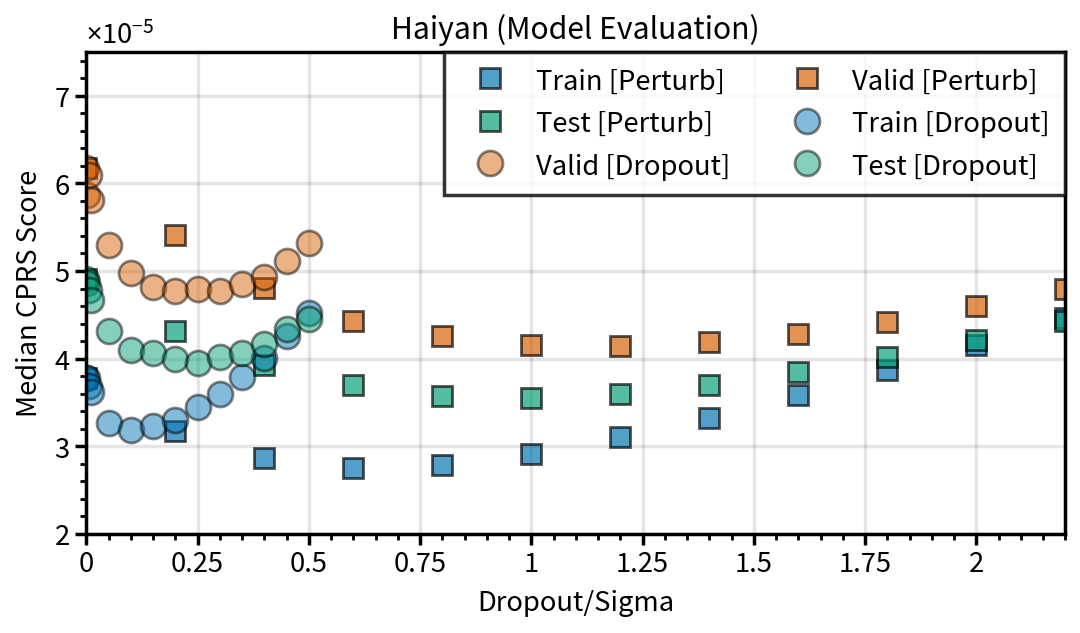

In [50]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.895,refaspect=2.031)
axs[0].plot(sigmas,[np.nanmedian(read_and_proc.flatten(storesigma_crps[obj]['train'])) for obj in sigmas],lw=0,label='Train [Perturb]',marker='s',mfc='C0',mew=1,mec='k',markersize=6.9,alpha=0.68)
axs[0].plot(sigmas,[np.nanmedian(read_and_proc.flatten(storesigma_crps[obj]['val'])) for obj in sigmas],lw=0,label='Valid [Perturb]',marker='s',mfc='C1',mew=1,mec='k',markersize=6.9,alpha=0.68)
axs[0].plot(sigmas,[np.nanmedian(read_and_proc.flatten(storesigma_crps[obj]['test'])) for obj in sigmas],lw=0,label='Test [Perturb]',marker='s',mfc='C2',mew=1,mec='k',markersize=6.9,alpha=0.68)

axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2trains'] for i in range(40)])) for obj in crps_performance],lw=0,label='Train [Dropout]',marker='o',mfc='C0',mew=1,mec='k',markersize=9,alpha=0.48)
axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2vals'] for i in range(40)])) for obj in crps_performance],lw=0,label='Valid [Dropout]',marker='o',mfc='C1',mew=1,mec='k',markersize=9,alpha=0.48)
axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2tests'] for i in range(40)])) for obj in crps_performance],lw=0,label='Test [Dropout]',marker='o',mfc='C2',mew=1,mec='k',markersize=9,alpha=0.48)
#axs[0].plot(0,np.nanmedian(read_and_proc.flatten(storesigma_crps[0]['train'])),marker='s',mfc='C0',mew=1,mec='k',markersize=9,alpha=0.8)
#axs[0].plot(0,np.nanmedian(read_and_proc.flatten(storesigma_crps[0]['val'])),marker='s',mfc='C1',mew=1,mec='k',markersize=9,alpha=0.8)
#axs[0].plot(0,np.nanmedian(read_and_proc.flatten(storesigma_crps[0]['test'])),marker='s',mfc='C2',mew=1,mec='k',markersize=9,alpha=0.8)
axs.legend(loc=1,ncols=2)
axs.format(xlabel='Dropout/Sigma',ylabel='Median CPRS Score',title='Haiyan (Model Evaluation)',ylim=[2e-5,7.5e-5])#,xlim=[-0.01,0.525])
#plt.savefig('../analysis/pic/climateinfo/CPRSmedian_revised_twomethods.png',dpi=600)
plt.show()

In [59]:
np.asarray([np.min(obj) for obj in storesigma_crps[1]['val']]).argmin()

26

In [61]:
np.asarray(storesigma_crps[1]['val'][26]).argmin()

2

In [266]:
valsplit_pert = 26
modelnum_pert = 2
bestmodel_pert = r2_performance[0][int(valsplit_pert)]['models'][int(modelnum_pert)][0]
fl_pert = new_structure(store_notensor[valsplit_pert]['train'][0],bestmodel_pert,'LW')
flsw_pert = new_structure(store_notensor[valsplit_pert]['train'][0],bestmodel_pert,'SW')
flas_pert = np.squeeze(np.dot(fl_pert,pcalw['lw'].components_[:20,:])).reshape(10,360,208)
flas_sw_pert = np.squeeze(np.dot(flsw_pert,pcasw['sw'].components_[:20,:])).reshape(10,360,208)

In [305]:
testtt = np.squeeze(np.dot(new_structure(((storeallsigma[0.2]['allpred_inputs'][26][2])[10])[0],bestmodel_pert,'LW'),pcalw['lw'].components_[:20,:])).reshape(10,360,208)

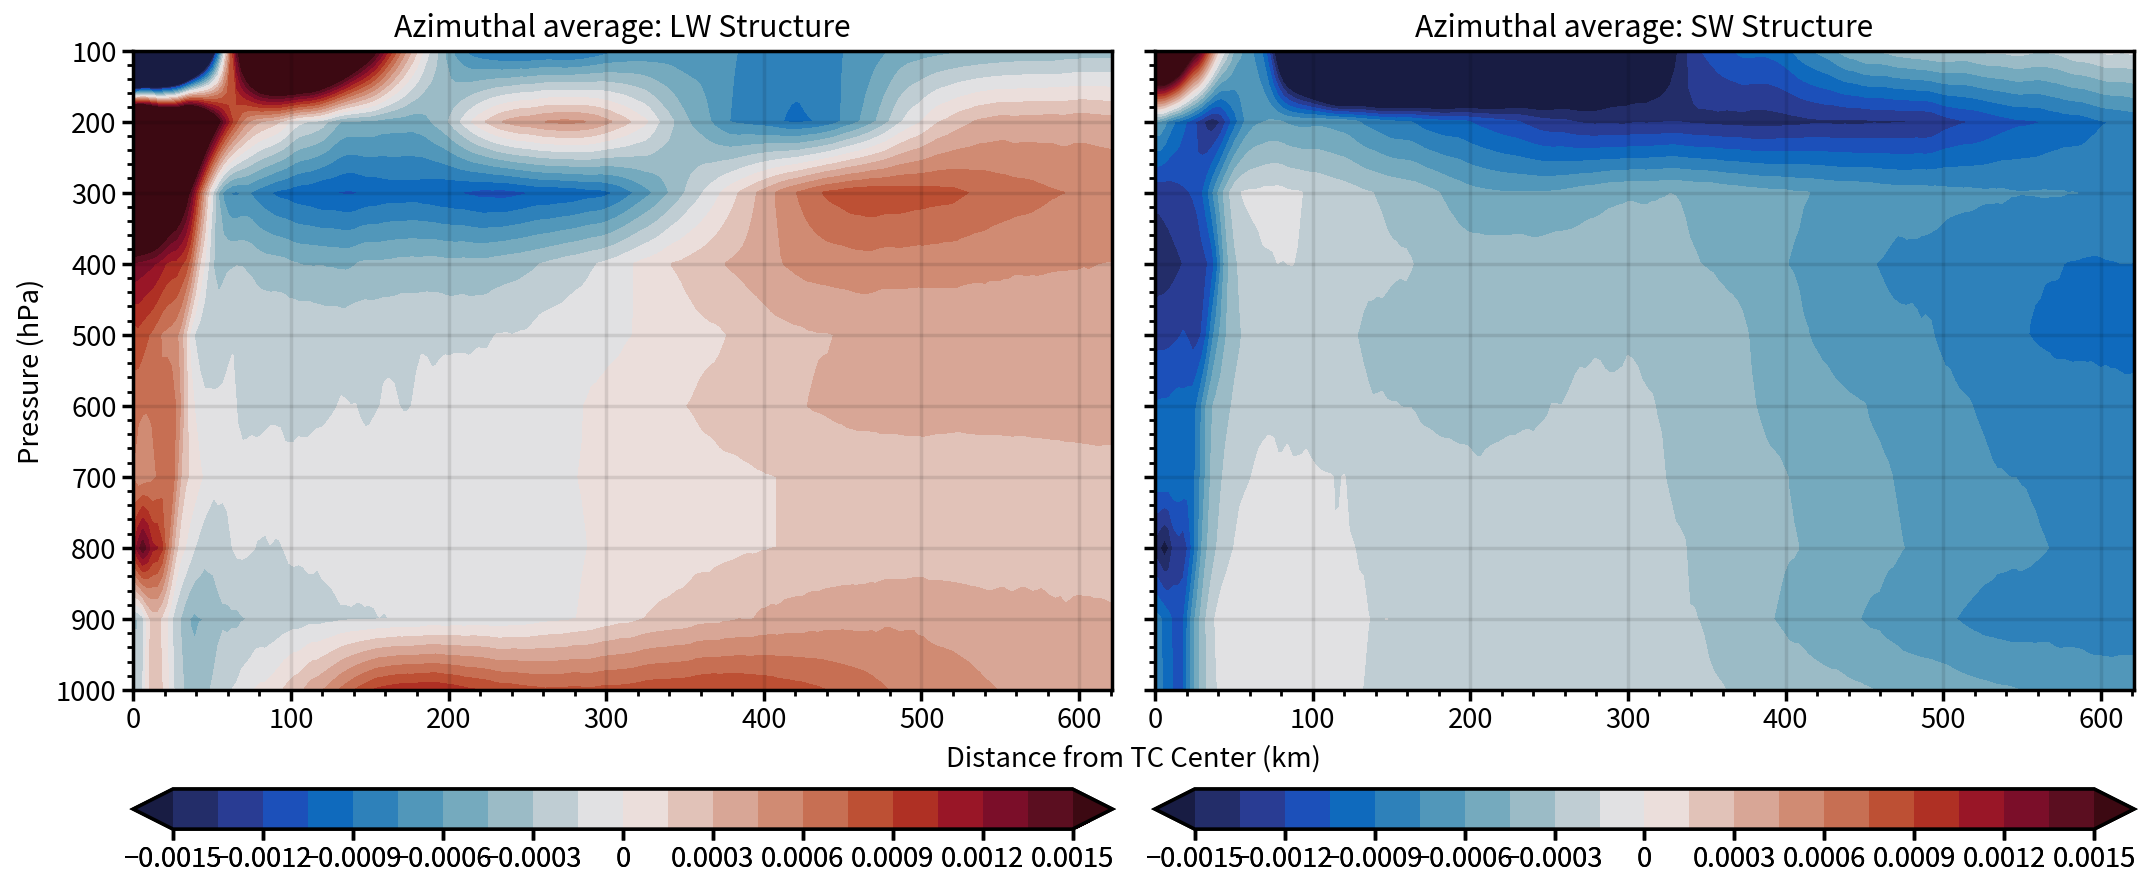

In [267]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=4.895,refaspect=1.531)
img = axs[0].contourf(np.linspace(0,207,208)*3,np.linspace(1000,100,10),np.mean(flas_pert,axis=1),cmap='balance',levels=np.linspace(-1.5e-3,1.5e-3,21),extend='both')#vmin=-0.5e-5,vmax=0.5e-5)
axs[0].colorbar(img,loc='b')
axs[0].format(xlabel='Distance from TC Center (km)',ylabel='Pressure (hPa)',title='Azimuthal average: LW Structure')
img2 = axs[1].contourf(np.linspace(0,207,208)*3,np.linspace(1000,100,10),np.mean(flas_sw_pert,axis=1),cmap='balance',levels=np.linspace(-1.5e-3,1.5e-3,21),extend='both')
axs[1].colorbar(img2,loc='b')
axs[1].format(xlabel='Distance from TC Center (km)',ylabel='Pressure (hPa)',title='Azimuthal average: SW Structure')
plt.show()

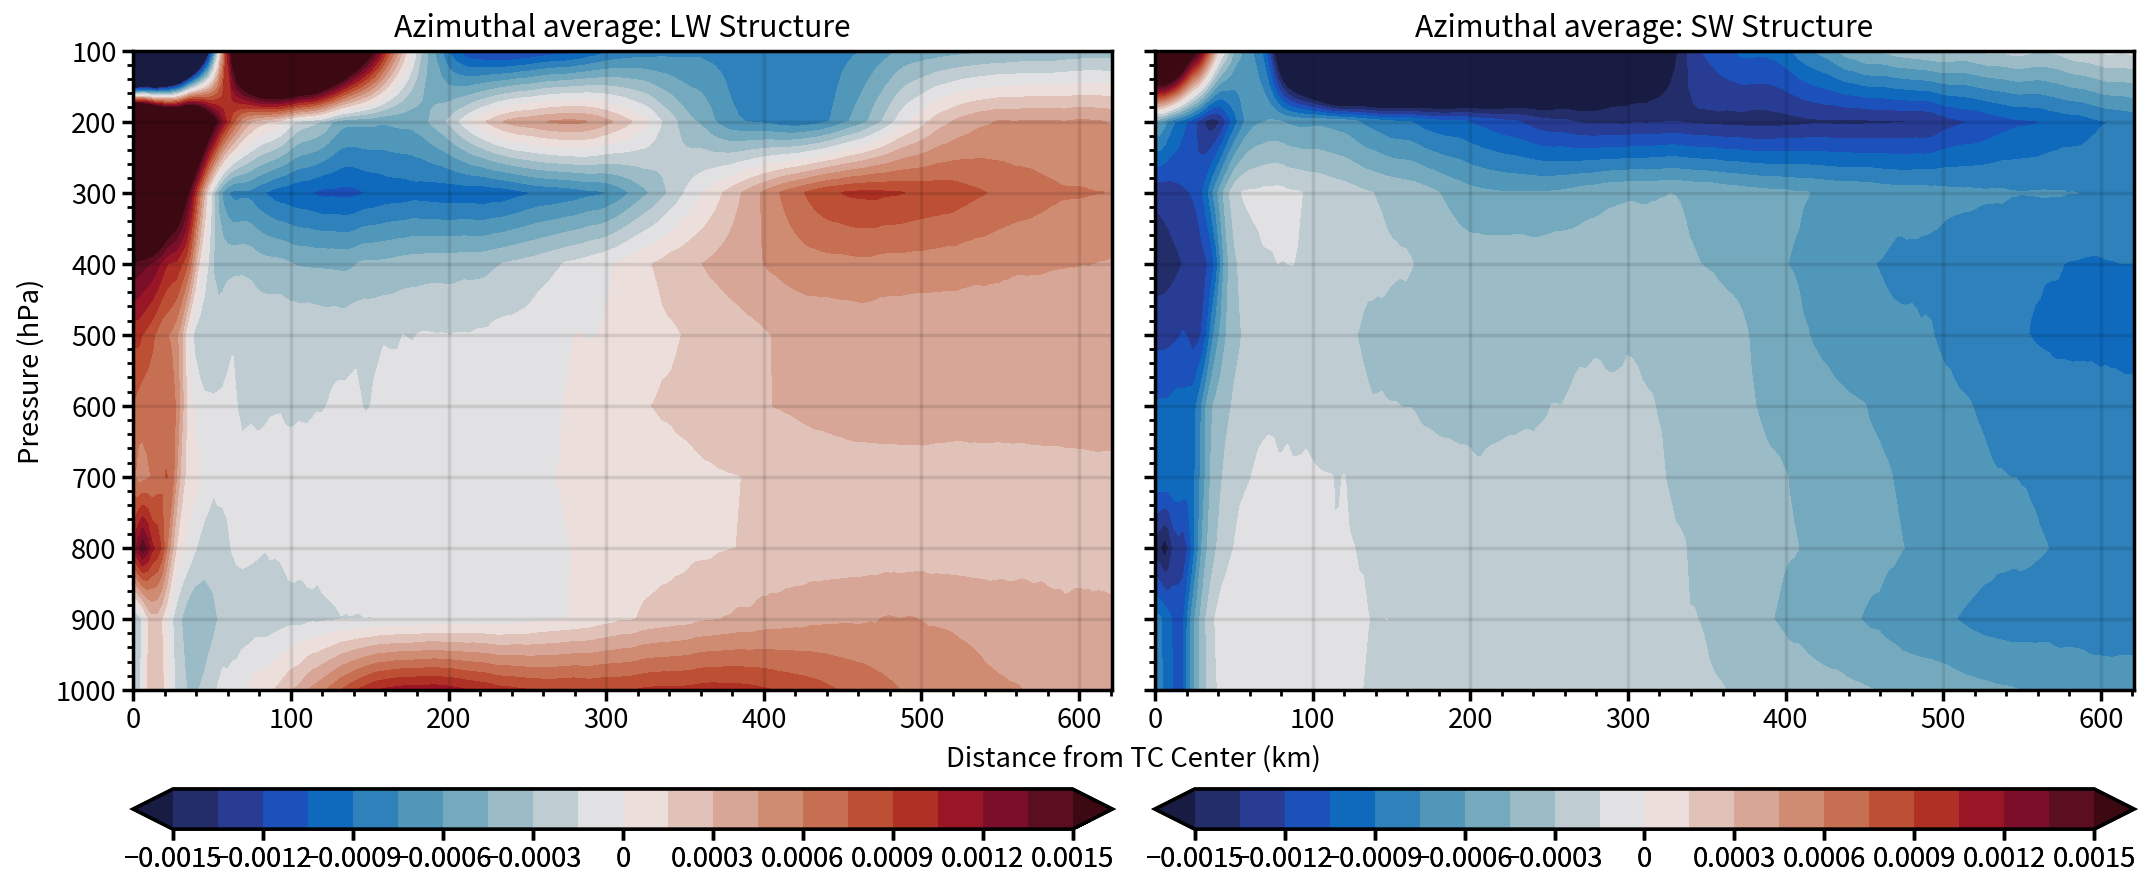

In [306]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=4.895,refaspect=1.531)
img = axs[0].contourf(np.linspace(0,207,208)*3,np.linspace(1000,100,10),np.mean(testtt,axis=1),cmap='balance',levels=np.linspace(-1.5e-3,1.5e-3,21),extend='both')#vmin=-0.5e-5,vmax=0.5e-5)
axs[0].colorbar(img,loc='b')
axs[0].format(xlabel='Distance from TC Center (km)',ylabel='Pressure (hPa)',title='Azimuthal average: LW Structure')
img2 = axs[1].contourf(np.linspace(0,207,208)*3,np.linspace(1000,100,10),np.mean(flas_sw_pert,axis=1),cmap='balance',levels=np.linspace(-1.5e-3,1.5e-3,21),extend='both')
axs[1].colorbar(img2,loc='b')
axs[1].format(xlabel='Distance from TC Center (km)',ylabel='Pressure (hPa)',title='Azimuthal average: SW Structure')
plt.show()

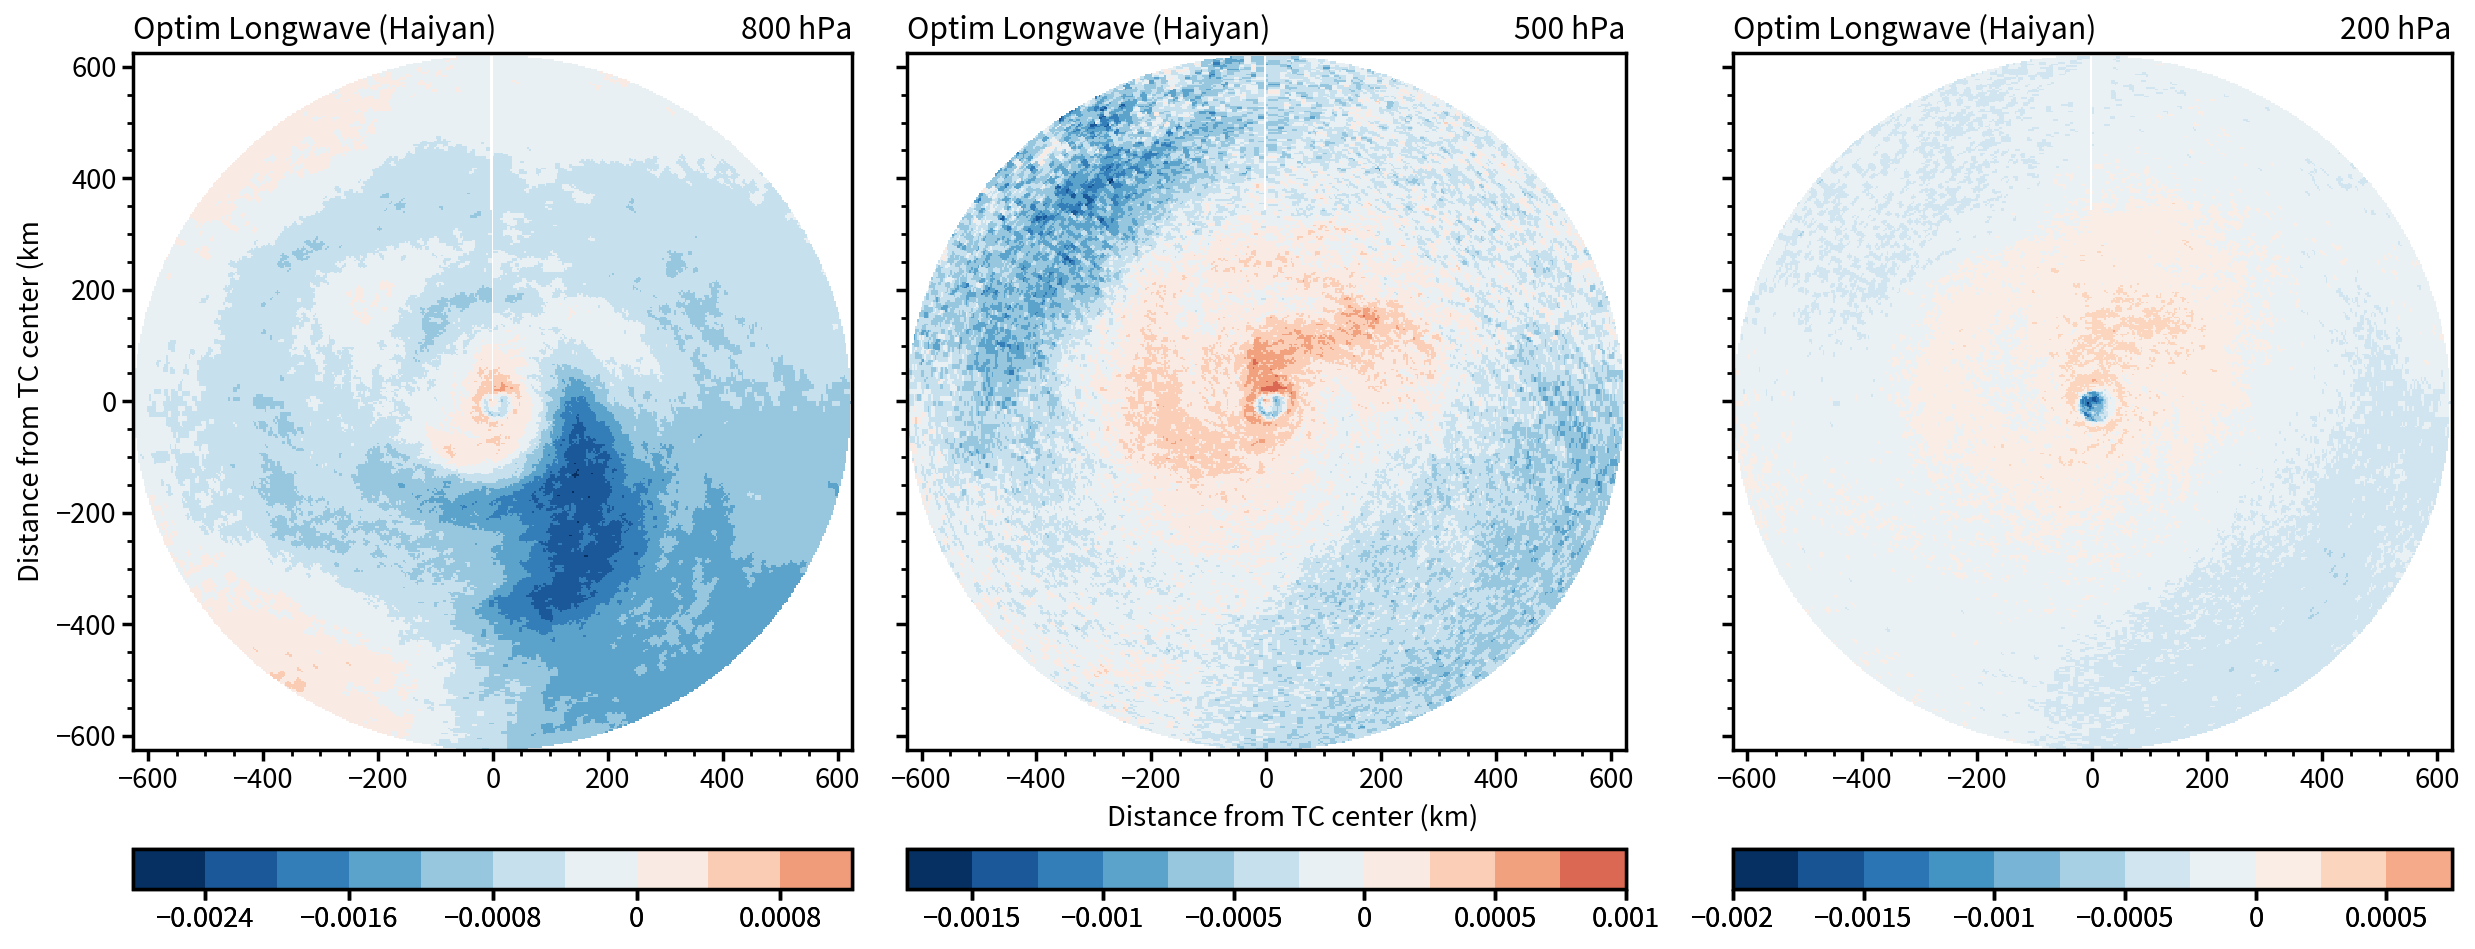

In [269]:
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
pressurelevel = [800,500,200]

fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.595,refaspect=1.031)
for i,obj in enumerate([2,5,-2]):
    #maps = axs[i].pcolormesh(np.ma.masked_inside(normalize(np.fliplr(np.flipud(read_and_proc.proc_tocart(optimLW[int(obj),...],ANGLE,True,False)))),-.65,.65),cmap='BuRd',vmin=-3,vmax=3)
    apl = -(np.fliplr(np.flipud(read_and_proc.proc_tocart(np.asarray(flas_pert)[i,...],ANGLE,True,False))))
    values = -(np.fliplr(np.flipud(read_and_proc.proc_tocart(np.asarray(flas_pert)[i,...],ANGLE,True,False))))[0,0]
    maps = axs[i].pcolormesh(np.linspace(-208,208,416)*3, np.linspace(-208,208,416)*3, np.ma.masked_where(apl==values,apl),cmap='BuRd')
    # hatches
    #stdd = np.nanstd(np.abs(np.asarray(test_toavg)[:,5,int(obj),...]))#,45)
    #aaaa = np.ma.masked_inside((np.fliplr(np.flipud(read_and_proc.proc_tocart(np.nanmean(np.asarray(test_toavg),axis=0)[5,int(obj),...],ANGLE,True,False)))),-stdd,stdd).mask
    #axs[i].contourf(aaaa.astype(int),levels=[0,0.5,1],hatches=["////","",""],alpha=0)
    # format
    axs[i].format(ltitle='Optim Longwave (Haiyan)',xlabel='Distance from TC center (km)', ylabel='Distance from TC center (km',rtitle=f'{pressurelevel[i]} hPa')
    axs[i].colorbar(maps,loc='b')
#plt.savefig('../analysis/pic/climateinfo/MCdropout_optimLW_mean_base.png',dpi=600)
plt.show()

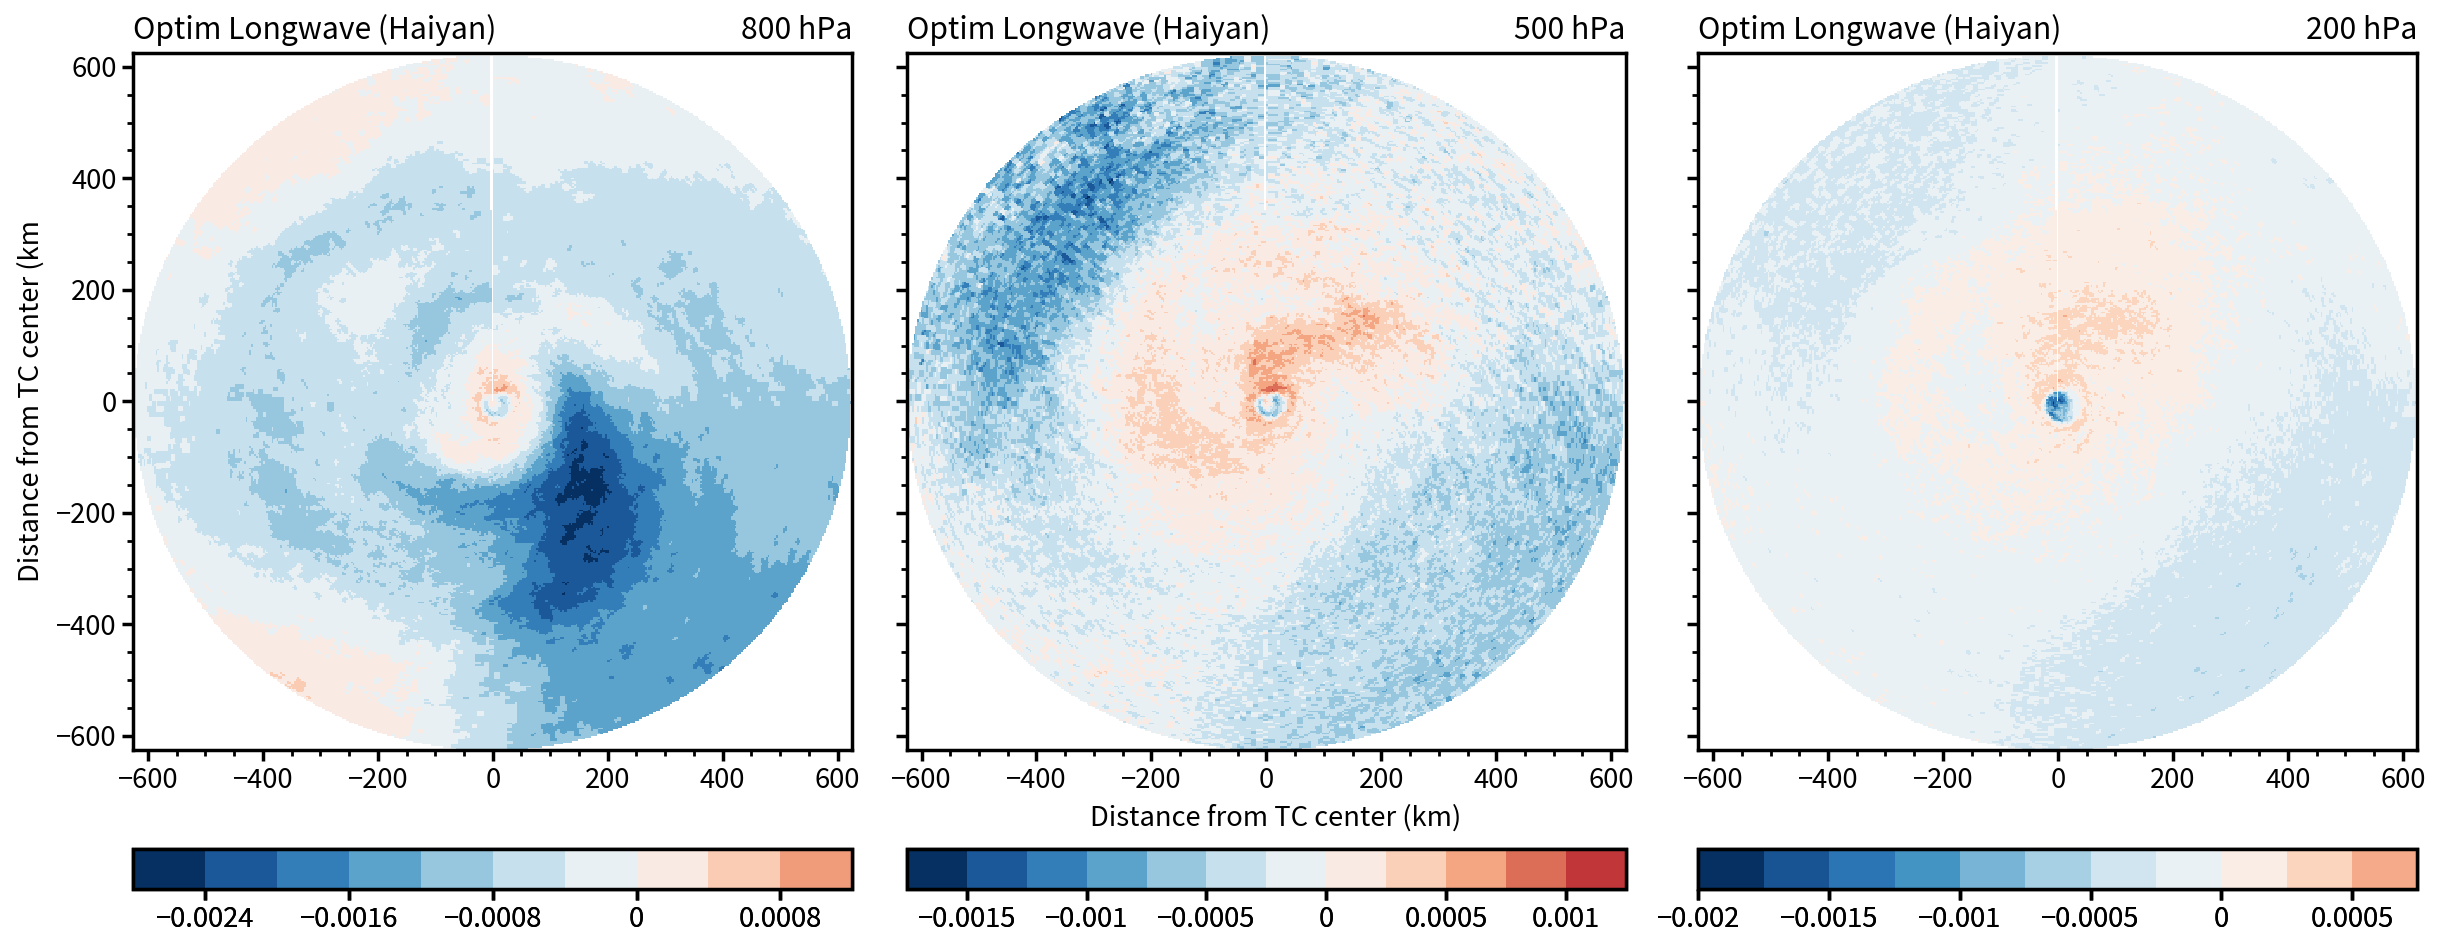

In [307]:
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
pressurelevel = [800,500,200]

fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.595,refaspect=1.031)
for i,obj in enumerate([2,5,-2]):
    #maps = axs[i].pcolormesh(np.ma.masked_inside(normalize(np.fliplr(np.flipud(read_and_proc.proc_tocart(optimLW[int(obj),...],ANGLE,True,False)))),-.65,.65),cmap='BuRd',vmin=-3,vmax=3)
    apl = -(np.fliplr(np.flipud(read_and_proc.proc_tocart(np.asarray(testtt)[i,...],ANGLE,True,False))))
    values = -(np.fliplr(np.flipud(read_and_proc.proc_tocart(np.asarray(testtt)[i,...],ANGLE,True,False))))[0,0]
    maps = axs[i].pcolormesh(np.linspace(-208,208,416)*3, np.linspace(-208,208,416)*3, np.ma.masked_where(apl==values,apl),cmap='BuRd')
    # hatches
    #stdd = np.nanstd(np.abs(np.asarray(test_toavg)[:,5,int(obj),...]))#,45)
    #aaaa = np.ma.masked_inside((np.fliplr(np.flipud(read_and_proc.proc_tocart(np.nanmean(np.asarray(test_toavg),axis=0)[5,int(obj),...],ANGLE,True,False)))),-stdd,stdd).mask
    #axs[i].contourf(aaaa.astype(int),levels=[0,0.5,1],hatches=["////","",""],alpha=0)
    # format
    axs[i].format(ltitle='Optim Longwave (Haiyan)',xlabel='Distance from TC center (km)', ylabel='Distance from TC center (km',rtitle=f'{pressurelevel[i]} hPa')
    axs[i].colorbar(maps,loc='b')
#plt.savefig('../analysis/pic/climateinfo/MCdropout_optimLW_mean_base.png',dpi=600)
plt.show()

In [276]:
(storeallsigma[1]['allpred'][valsplit_pert][modelnum_pert])[0]['train'].shape

(926,)

# Validation

In [21]:
LW,SW = (np.asarray(store_notensor[valsplit]['train'][0])[:,-40:-20]),(np.asarray(store_notensor[valsplit]['train'][0])[:,-20:])
a2lw = benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[0]
a2sw = benchmark.model_outweights_all(bestmodel)[0][-2][0].detach().numpy()[1]
sumss_lw = np.sqrt(np.sum((benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()/np.std(LW,axis=0))**2))
sumss_sw = np.sqrt(np.sum((benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()/np.std(SW,axis=0))**2))
a_lw = np.abs(a2lw)*sumss_lw
a_sw = np.abs(a2sw)*sumss_sw
#benchmark.model_outweights_all(bestmodel_pert)[0][-1][0].detach().numpy()

In [23]:
b2 = benchmark.model_outweights_all(bestmodel)[0][-1][0].detach().numpy()
a1lw = benchmark.model_outweights_all(bestmodel)[0][0][0].detach().numpy()
b1lw = benchmark.model_outweights_all(bestmodel)[0][1][0].detach().numpy()
a1sw = benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()
b1sw = benchmark.model_outweights_all(bestmodel)[0][3][0].detach().numpy()

In [24]:
lw_tosum,sw_tosum = [],[]
for i in range(20):
    lw_tosum.append(a1lw[i]*np.mean(LW[:,i])/np.std(LW[:,i]))
    sw_tosum.append(a1sw[i]*np.mean(SW[:,i])/np.std(SW[:,i]))
LW_sum = np.sum(np.asarray(lw_tosum))
SW_sum = np.sum(np.asarray(sw_tosum))

In [25]:
b = b2 + a2lw * (b1lw - LW_sum) + a2sw * (b1sw - SW_sum)

In [26]:
b

0.0001576054487198577

In [29]:
#aaaa,bbbb = benchmark.model_outweights_all(bestmodel_pert)[0][-2][0].detach().numpy()[0],benchmark.model_outweights_all(bestmodel_pert)[0][-2][0].detach().numpy()[1]
predssss = a_lw*np.dot(np.asarray([obj[-40:-20] for obj in (store_notensor[valsplit]['train'][0])]),fl)+\
a_sw*np.dot(np.asarray([obj[-20:] for obj in (store_notensor[valsplit]['train'][0])]),flsw)+ b

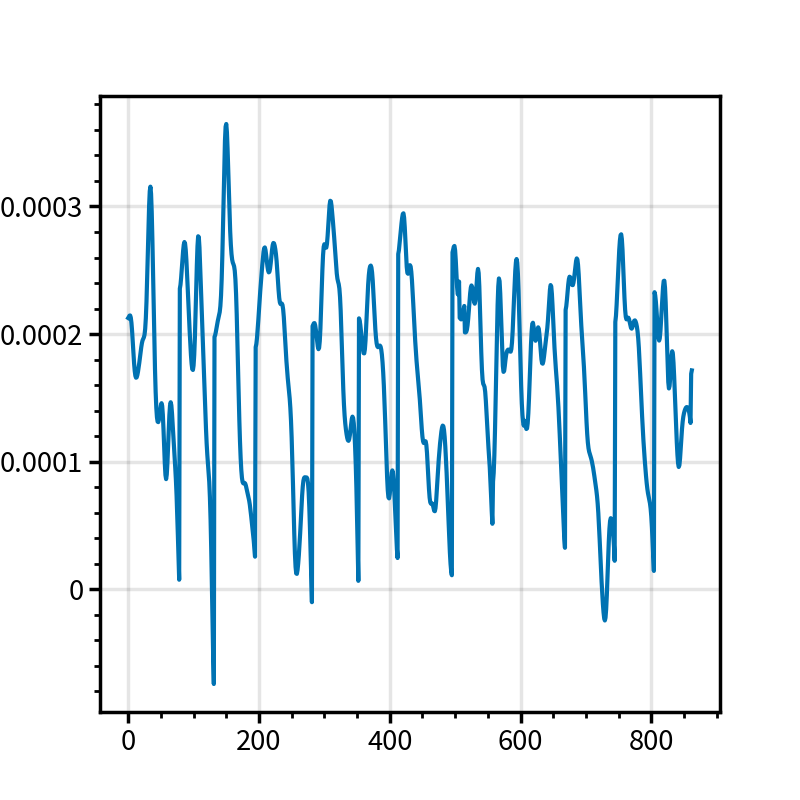

In [30]:
plt.plot(predssss)
#plt.xlim(0,50)
plt.show()

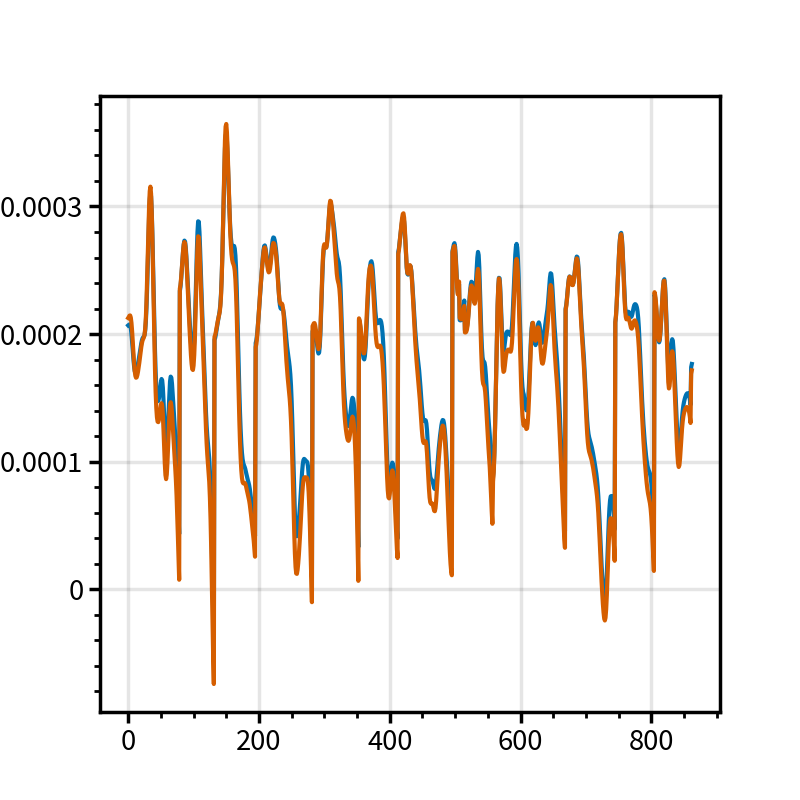

In [34]:
plt.plot(bestmodel(torch.FloatTensor(store_notensor[valsplit]['train'][0]).to('cpu')).detach().numpy().transpose()[0])
plt.plot(predssss)
#plt.xlim(0,50)
plt.show()
#plt.show()

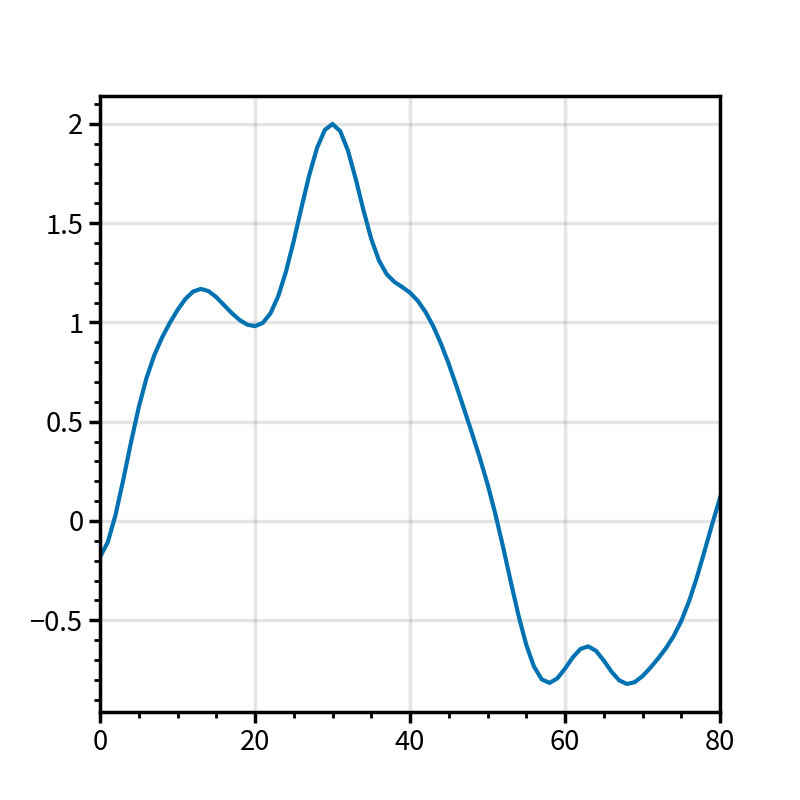

In [119]:
plt.plot(np.dot(np.asarray([obj[-40:-20] for obj in (store_notensor[valsplit_pert]['test'][0])]),fl_pert))
plt.xlim(0,80)
plt.show()